## 4.3　改良版 word2vec の学習

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
os.chdir('/Users/yuta.shimizu/Downloads/ML/deep-learning-from-scratch-2-master/ch01')
sys.path.append(os.pardir)

In [3]:
import pickle
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss
from common import config
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu
from dataset import ptb
from common.util import most_similar
from common.util import analogy

### 4.3.1　CBOW モデルの実装

`window_size` は、左右の単語を何個までコンテキストにするかを決める引数である。

In [4]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h += 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

イニシャライザでは、`layer` に `Embedding`、`self.ns_loss` に `NegativeSamplingLoss` を代入している。

In [5]:
del CBOW

### 4.3.2　CBOW モデルの学習コード

In [6]:
from ch04.cbow import CBOW

In [7]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

In [8]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

In [9]:
print(len(word_to_id))
print(len(id_to_word))
print(len(corpus))
print(contexts.shape)
print(target.shape)

10000
10000
929589
(929579, 10)
(929579,)


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 2[s] | loss 4.13
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 3[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 4[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 4[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 5[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 6[s] | loss 3.38
| epoch 1 |  iter 201 / 9295 | time 6[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 7[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 7[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 8[s] | loss 3.03
| epoch 1 |  iter 281 / 9295 | time 9[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 9[s] | loss 2.93
| epoch 1 |  iter 321 / 9295 | time 10[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 11[s] | loss 2.84
| epoch 1 |  iter 361 / 9295 | time 11[s] | loss 2

| epoch 1 |  iter 3021 / 9295 | time 98[s] | loss 2.43
| epoch 1 |  iter 3041 / 9295 | time 98[s] | loss 2.44
| epoch 1 |  iter 3061 / 9295 | time 99[s] | loss 2.44
| epoch 1 |  iter 3081 / 9295 | time 100[s] | loss 2.42
| epoch 1 |  iter 3101 / 9295 | time 100[s] | loss 2.42
| epoch 1 |  iter 3121 / 9295 | time 101[s] | loss 2.49
| epoch 1 |  iter 3141 / 9295 | time 102[s] | loss 2.45
| epoch 1 |  iter 3161 / 9295 | time 102[s] | loss 2.45
| epoch 1 |  iter 3181 / 9295 | time 103[s] | loss 2.41
| epoch 1 |  iter 3201 / 9295 | time 103[s] | loss 2.44
| epoch 1 |  iter 3221 / 9295 | time 104[s] | loss 2.48
| epoch 1 |  iter 3241 / 9295 | time 105[s] | loss 2.43
| epoch 1 |  iter 3261 / 9295 | time 105[s] | loss 2.47
| epoch 1 |  iter 3281 / 9295 | time 106[s] | loss 2.42
| epoch 1 |  iter 3301 / 9295 | time 107[s] | loss 2.44
| epoch 1 |  iter 3321 / 9295 | time 107[s] | loss 2.41
| epoch 1 |  iter 3341 / 9295 | time 108[s] | loss 2.42
| epoch 1 |  iter 3361 / 9295 | time 109[s] | loss 

| epoch 1 |  iter 5941 / 9295 | time 1905[s] | loss 2.34
| epoch 1 |  iter 5961 / 9295 | time 1906[s] | loss 2.32
| epoch 1 |  iter 5981 / 9295 | time 1906[s] | loss 2.33
| epoch 1 |  iter 6001 / 9295 | time 1907[s] | loss 2.34
| epoch 1 |  iter 6021 / 9295 | time 1908[s] | loss 2.33
| epoch 1 |  iter 6041 / 9295 | time 1908[s] | loss 2.33
| epoch 1 |  iter 6061 / 9295 | time 1909[s] | loss 2.30
| epoch 1 |  iter 6081 / 9295 | time 1910[s] | loss 2.32
| epoch 1 |  iter 6101 / 9295 | time 1910[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 1911[s] | loss 2.33
| epoch 1 |  iter 6141 / 9295 | time 1912[s] | loss 2.28
| epoch 1 |  iter 6161 / 9295 | time 1912[s] | loss 2.28
| epoch 1 |  iter 6181 / 9295 | time 1913[s] | loss 2.33
| epoch 1 |  iter 6201 / 9295 | time 1914[s] | loss 2.33
| epoch 1 |  iter 6221 / 9295 | time 1914[s] | loss 2.31
| epoch 1 |  iter 6241 / 9295 | time 1915[s] | loss 2.27
| epoch 1 |  iter 6261 / 9295 | time 1916[s] | loss 2.35
| epoch 1 |  iter 6281 / 9295 |

| epoch 1 |  iter 8821 / 9295 | time 2000[s] | loss 2.23
| epoch 1 |  iter 8841 / 9295 | time 2000[s] | loss 2.22
| epoch 1 |  iter 8861 / 9295 | time 2001[s] | loss 2.21
| epoch 1 |  iter 8881 / 9295 | time 2002[s] | loss 2.23
| epoch 1 |  iter 8901 / 9295 | time 2002[s] | loss 2.20
| epoch 1 |  iter 8921 / 9295 | time 2003[s] | loss 2.21
| epoch 1 |  iter 8941 / 9295 | time 2004[s] | loss 2.24
| epoch 1 |  iter 8961 / 9295 | time 2004[s] | loss 2.26
| epoch 1 |  iter 8981 / 9295 | time 2005[s] | loss 2.21
| epoch 1 |  iter 9001 / 9295 | time 2006[s] | loss 2.25
| epoch 1 |  iter 9021 / 9295 | time 2006[s] | loss 2.21
| epoch 1 |  iter 9041 / 9295 | time 2007[s] | loss 2.24
| epoch 1 |  iter 9061 / 9295 | time 2008[s] | loss 2.21
| epoch 1 |  iter 9081 / 9295 | time 2008[s] | loss 2.24
| epoch 1 |  iter 9101 / 9295 | time 2009[s] | loss 2.22
| epoch 1 |  iter 9121 / 9295 | time 2010[s] | loss 2.23
| epoch 1 |  iter 9141 / 9295 | time 2010[s] | loss 2.20
| epoch 1 |  iter 9161 / 9295 |

| epoch 2 |  iter 2421 / 9295 | time 2094[s] | loss 2.15
| epoch 2 |  iter 2441 / 9295 | time 2095[s] | loss 2.13
| epoch 2 |  iter 2461 / 9295 | time 2096[s] | loss 2.13
| epoch 2 |  iter 2481 / 9295 | time 2096[s] | loss 2.14
| epoch 2 |  iter 2501 / 9295 | time 2097[s] | loss 2.10
| epoch 2 |  iter 2521 / 9295 | time 2098[s] | loss 2.10
| epoch 2 |  iter 2541 / 9295 | time 2098[s] | loss 2.12
| epoch 2 |  iter 2561 / 9295 | time 2099[s] | loss 2.10
| epoch 2 |  iter 2581 / 9295 | time 2100[s] | loss 2.15
| epoch 2 |  iter 2601 / 9295 | time 2100[s] | loss 2.10
| epoch 2 |  iter 2621 / 9295 | time 2101[s] | loss 2.11
| epoch 2 |  iter 2641 / 9295 | time 2102[s] | loss 2.15
| epoch 2 |  iter 2661 / 9295 | time 2102[s] | loss 2.08
| epoch 2 |  iter 2681 / 9295 | time 2103[s] | loss 2.17
| epoch 2 |  iter 2701 / 9295 | time 2104[s] | loss 2.12
| epoch 2 |  iter 2721 / 9295 | time 2104[s] | loss 2.13
| epoch 2 |  iter 2741 / 9295 | time 2105[s] | loss 2.09
| epoch 2 |  iter 2761 / 9295 |

| epoch 2 |  iter 5301 / 9295 | time 2189[s] | loss 2.07
| epoch 2 |  iter 5321 / 9295 | time 2189[s] | loss 2.07
| epoch 2 |  iter 5341 / 9295 | time 2190[s] | loss 2.08
| epoch 2 |  iter 5361 / 9295 | time 2191[s] | loss 2.04
| epoch 2 |  iter 5381 / 9295 | time 2191[s] | loss 2.08
| epoch 2 |  iter 5401 / 9295 | time 2192[s] | loss 2.09
| epoch 2 |  iter 5421 / 9295 | time 2193[s] | loss 2.11
| epoch 2 |  iter 5441 / 9295 | time 2193[s] | loss 2.09
| epoch 2 |  iter 5461 / 9295 | time 2194[s] | loss 2.07
| epoch 2 |  iter 5481 / 9295 | time 2195[s] | loss 2.05
| epoch 2 |  iter 5501 / 9295 | time 2195[s] | loss 2.07
| epoch 2 |  iter 5521 / 9295 | time 2196[s] | loss 2.04
| epoch 2 |  iter 5541 / 9295 | time 2197[s] | loss 2.06
| epoch 2 |  iter 5561 / 9295 | time 2197[s] | loss 2.10
| epoch 2 |  iter 5581 / 9295 | time 2198[s] | loss 2.05
| epoch 2 |  iter 5601 / 9295 | time 2199[s] | loss 2.06
| epoch 2 |  iter 5621 / 9295 | time 2199[s] | loss 2.11
| epoch 2 |  iter 5641 / 9295 |

| epoch 2 |  iter 8181 / 9295 | time 2283[s] | loss 2.01
| epoch 2 |  iter 8201 / 9295 | time 2284[s] | loss 2.04
| epoch 2 |  iter 8221 / 9295 | time 2284[s] | loss 2.02
| epoch 2 |  iter 8241 / 9295 | time 2285[s] | loss 2.03
| epoch 2 |  iter 8261 / 9295 | time 2286[s] | loss 2.05
| epoch 2 |  iter 8281 / 9295 | time 2286[s] | loss 2.01
| epoch 2 |  iter 8301 / 9295 | time 2287[s] | loss 2.01
| epoch 2 |  iter 8321 / 9295 | time 2288[s] | loss 2.05
| epoch 2 |  iter 8341 / 9295 | time 2288[s] | loss 2.04
| epoch 2 |  iter 8361 / 9295 | time 2289[s] | loss 2.03
| epoch 2 |  iter 8381 / 9295 | time 2290[s] | loss 2.08
| epoch 2 |  iter 8401 / 9295 | time 2290[s] | loss 2.04
| epoch 2 |  iter 8421 / 9295 | time 2291[s] | loss 2.01
| epoch 2 |  iter 8441 / 9295 | time 2292[s] | loss 2.07
| epoch 2 |  iter 8461 / 9295 | time 2292[s] | loss 2.00
| epoch 2 |  iter 8481 / 9295 | time 2293[s] | loss 1.99
| epoch 2 |  iter 8501 / 9295 | time 2294[s] | loss 2.00
| epoch 2 |  iter 8521 / 9295 |

| epoch 3 |  iter 1781 / 9295 | time 2379[s] | loss 1.92
| epoch 3 |  iter 1801 / 9295 | time 2380[s] | loss 1.94
| epoch 3 |  iter 1821 / 9295 | time 2380[s] | loss 1.95
| epoch 3 |  iter 1841 / 9295 | time 2381[s] | loss 1.92
| epoch 3 |  iter 1861 / 9295 | time 2382[s] | loss 1.93
| epoch 3 |  iter 1881 / 9295 | time 2382[s] | loss 1.93
| epoch 3 |  iter 1901 / 9295 | time 2383[s] | loss 1.93
| epoch 3 |  iter 1921 / 9295 | time 2383[s] | loss 1.98
| epoch 3 |  iter 1941 / 9295 | time 2384[s] | loss 1.94
| epoch 3 |  iter 1961 / 9295 | time 2385[s] | loss 1.94
| epoch 3 |  iter 1981 / 9295 | time 2385[s] | loss 1.93
| epoch 3 |  iter 2001 / 9295 | time 2386[s] | loss 1.95
| epoch 3 |  iter 2021 / 9295 | time 2387[s] | loss 1.96
| epoch 3 |  iter 2041 / 9295 | time 2387[s] | loss 1.96
| epoch 3 |  iter 2061 / 9295 | time 2388[s] | loss 1.96
| epoch 3 |  iter 2081 / 9295 | time 2389[s] | loss 1.91
| epoch 3 |  iter 2101 / 9295 | time 2389[s] | loss 1.94
| epoch 3 |  iter 2121 / 9295 |

| epoch 3 |  iter 4661 / 9295 | time 2475[s] | loss 1.92
| epoch 3 |  iter 4681 / 9295 | time 2475[s] | loss 1.90
| epoch 3 |  iter 4701 / 9295 | time 2476[s] | loss 1.92
| epoch 3 |  iter 4721 / 9295 | time 2477[s] | loss 1.91
| epoch 3 |  iter 4741 / 9295 | time 2477[s] | loss 1.90
| epoch 3 |  iter 4761 / 9295 | time 2478[s] | loss 1.96
| epoch 3 |  iter 4781 / 9295 | time 2479[s] | loss 1.94
| epoch 3 |  iter 4801 / 9295 | time 2479[s] | loss 1.93
| epoch 3 |  iter 4821 / 9295 | time 2480[s] | loss 1.93
| epoch 3 |  iter 4841 / 9295 | time 2481[s] | loss 1.92
| epoch 3 |  iter 4861 / 9295 | time 2481[s] | loss 1.89
| epoch 3 |  iter 4881 / 9295 | time 2482[s] | loss 1.92
| epoch 3 |  iter 4901 / 9295 | time 2483[s] | loss 1.94
| epoch 3 |  iter 4921 / 9295 | time 2483[s] | loss 1.90
| epoch 3 |  iter 4941 / 9295 | time 2484[s] | loss 1.96
| epoch 3 |  iter 4961 / 9295 | time 2485[s] | loss 1.93
| epoch 3 |  iter 4981 / 9295 | time 2485[s] | loss 1.93
| epoch 3 |  iter 5001 / 9295 |

| epoch 3 |  iter 7541 / 9295 | time 2571[s] | loss 1.91
| epoch 3 |  iter 7561 / 9295 | time 2572[s] | loss 1.90
| epoch 3 |  iter 7581 / 9295 | time 2572[s] | loss 1.93
| epoch 3 |  iter 7601 / 9295 | time 2573[s] | loss 1.89
| epoch 3 |  iter 7621 / 9295 | time 2574[s] | loss 1.90
| epoch 3 |  iter 7641 / 9295 | time 2574[s] | loss 1.91
| epoch 3 |  iter 7661 / 9295 | time 2575[s] | loss 1.90
| epoch 3 |  iter 7681 / 9295 | time 2576[s] | loss 1.90
| epoch 3 |  iter 7701 / 9295 | time 2576[s] | loss 1.84
| epoch 3 |  iter 7721 / 9295 | time 2577[s] | loss 1.88
| epoch 3 |  iter 7741 / 9295 | time 2578[s] | loss 1.91
| epoch 3 |  iter 7761 / 9295 | time 2578[s] | loss 1.90
| epoch 3 |  iter 7781 / 9295 | time 2579[s] | loss 1.91
| epoch 3 |  iter 7801 / 9295 | time 2580[s] | loss 1.90
| epoch 3 |  iter 7821 / 9295 | time 2580[s] | loss 1.89
| epoch 3 |  iter 7841 / 9295 | time 2581[s] | loss 1.89
| epoch 3 |  iter 7861 / 9295 | time 2582[s] | loss 1.89
| epoch 3 |  iter 7881 / 9295 |

| epoch 4 |  iter 1141 / 9295 | time 2666[s] | loss 1.83
| epoch 4 |  iter 1161 / 9295 | time 2667[s] | loss 1.84
| epoch 4 |  iter 1181 / 9295 | time 2667[s] | loss 1.79
| epoch 4 |  iter 1201 / 9295 | time 2668[s] | loss 1.81
| epoch 4 |  iter 1221 / 9295 | time 2669[s] | loss 1.81
| epoch 4 |  iter 1241 / 9295 | time 2669[s] | loss 1.83
| epoch 4 |  iter 1261 / 9295 | time 2670[s] | loss 1.83
| epoch 4 |  iter 1281 / 9295 | time 2671[s] | loss 1.81
| epoch 4 |  iter 1301 / 9295 | time 2671[s] | loss 1.79
| epoch 4 |  iter 1321 / 9295 | time 2672[s] | loss 1.86
| epoch 4 |  iter 1341 / 9295 | time 2673[s] | loss 1.80
| epoch 4 |  iter 1361 / 9295 | time 2673[s] | loss 1.83
| epoch 4 |  iter 1381 / 9295 | time 2674[s] | loss 1.82
| epoch 4 |  iter 1401 / 9295 | time 2675[s] | loss 1.78
| epoch 4 |  iter 1421 / 9295 | time 2675[s] | loss 1.79
| epoch 4 |  iter 1441 / 9295 | time 2676[s] | loss 1.82
| epoch 4 |  iter 1461 / 9295 | time 2677[s] | loss 1.81
| epoch 4 |  iter 1481 / 9295 |

| epoch 4 |  iter 4021 / 9295 | time 2760[s] | loss 1.81
| epoch 4 |  iter 4041 / 9295 | time 2761[s] | loss 1.80
| epoch 4 |  iter 4061 / 9295 | time 2762[s] | loss 1.84
| epoch 4 |  iter 4081 / 9295 | time 2762[s] | loss 1.80
| epoch 4 |  iter 4101 / 9295 | time 2763[s] | loss 1.80
| epoch 4 |  iter 4121 / 9295 | time 2764[s] | loss 1.79
| epoch 4 |  iter 4141 / 9295 | time 2764[s] | loss 1.78
| epoch 4 |  iter 4161 / 9295 | time 2765[s] | loss 1.81
| epoch 4 |  iter 4181 / 9295 | time 2766[s] | loss 1.85
| epoch 4 |  iter 4201 / 9295 | time 2766[s] | loss 1.83
| epoch 4 |  iter 4221 / 9295 | time 2767[s] | loss 1.82
| epoch 4 |  iter 4241 / 9295 | time 2768[s] | loss 1.83
| epoch 4 |  iter 4261 / 9295 | time 2768[s] | loss 1.86
| epoch 4 |  iter 4281 / 9295 | time 2769[s] | loss 1.81
| epoch 4 |  iter 4301 / 9295 | time 2770[s] | loss 1.80
| epoch 4 |  iter 4321 / 9295 | time 2770[s] | loss 1.83
| epoch 4 |  iter 4341 / 9295 | time 2771[s] | loss 1.79
| epoch 4 |  iter 4361 / 9295 |

| epoch 4 |  iter 6901 / 9295 | time 2856[s] | loss 1.84
| epoch 4 |  iter 6921 / 9295 | time 2857[s] | loss 1.81
| epoch 4 |  iter 6941 / 9295 | time 2858[s] | loss 1.83
| epoch 4 |  iter 6961 / 9295 | time 2858[s] | loss 1.82
| epoch 4 |  iter 6981 / 9295 | time 2859[s] | loss 1.77
| epoch 4 |  iter 7001 / 9295 | time 2860[s] | loss 1.81
| epoch 4 |  iter 7021 / 9295 | time 2860[s] | loss 1.83
| epoch 4 |  iter 7041 / 9295 | time 2861[s] | loss 1.83
| epoch 4 |  iter 7061 / 9295 | time 2862[s] | loss 1.83
| epoch 4 |  iter 7081 / 9295 | time 2862[s] | loss 1.82
| epoch 4 |  iter 7101 / 9295 | time 2863[s] | loss 1.80
| epoch 4 |  iter 7121 / 9295 | time 2864[s] | loss 1.81
| epoch 4 |  iter 7141 / 9295 | time 2864[s] | loss 1.76
| epoch 4 |  iter 7161 / 9295 | time 2865[s] | loss 1.82
| epoch 4 |  iter 7181 / 9295 | time 2866[s] | loss 1.79
| epoch 4 |  iter 7201 / 9295 | time 2866[s] | loss 1.82
| epoch 4 |  iter 7221 / 9295 | time 2867[s] | loss 1.82
| epoch 4 |  iter 7241 / 9295 |

| epoch 5 |  iter 501 / 9295 | time 2952[s] | loss 1.73
| epoch 5 |  iter 521 / 9295 | time 2952[s] | loss 1.71
| epoch 5 |  iter 541 / 9295 | time 2953[s] | loss 1.71
| epoch 5 |  iter 561 / 9295 | time 2953[s] | loss 1.73
| epoch 5 |  iter 581 / 9295 | time 2954[s] | loss 1.72
| epoch 5 |  iter 601 / 9295 | time 2955[s] | loss 1.73
| epoch 5 |  iter 621 / 9295 | time 2955[s] | loss 1.71
| epoch 5 |  iter 641 / 9295 | time 2956[s] | loss 1.75
| epoch 5 |  iter 661 / 9295 | time 2957[s] | loss 1.71
| epoch 5 |  iter 681 / 9295 | time 2957[s] | loss 1.72
| epoch 5 |  iter 701 / 9295 | time 2958[s] | loss 1.72
| epoch 5 |  iter 721 / 9295 | time 2959[s] | loss 1.74
| epoch 5 |  iter 741 / 9295 | time 2959[s] | loss 1.71
| epoch 5 |  iter 761 / 9295 | time 2960[s] | loss 1.74
| epoch 5 |  iter 781 / 9295 | time 2961[s] | loss 1.73
| epoch 5 |  iter 801 / 9295 | time 2961[s] | loss 1.70
| epoch 5 |  iter 821 / 9295 | time 2962[s] | loss 1.70
| epoch 5 |  iter 841 / 9295 | time 2963[s] | lo

| epoch 5 |  iter 3401 / 9295 | time 3046[s] | loss 1.72
| epoch 5 |  iter 3421 / 9295 | time 3047[s] | loss 1.72
| epoch 5 |  iter 3441 / 9295 | time 3048[s] | loss 1.72
| epoch 5 |  iter 3461 / 9295 | time 3048[s] | loss 1.72
| epoch 5 |  iter 3481 / 9295 | time 3049[s] | loss 1.71
| epoch 5 |  iter 3501 / 9295 | time 3050[s] | loss 1.71
| epoch 5 |  iter 3521 / 9295 | time 3050[s] | loss 1.73
| epoch 5 |  iter 3541 / 9295 | time 3051[s] | loss 1.73
| epoch 5 |  iter 3561 / 9295 | time 3052[s] | loss 1.74
| epoch 5 |  iter 3581 / 9295 | time 3052[s] | loss 1.76
| epoch 5 |  iter 3601 / 9295 | time 3053[s] | loss 1.75
| epoch 5 |  iter 3621 / 9295 | time 3054[s] | loss 1.74
| epoch 5 |  iter 3641 / 9295 | time 3054[s] | loss 1.71
| epoch 5 |  iter 3661 / 9295 | time 3055[s] | loss 1.68
| epoch 5 |  iter 3681 / 9295 | time 3056[s] | loss 1.75
| epoch 5 |  iter 3701 / 9295 | time 3056[s] | loss 1.71
| epoch 5 |  iter 3721 / 9295 | time 3057[s] | loss 1.73
| epoch 5 |  iter 3741 / 9295 |

| epoch 5 |  iter 6281 / 9295 | time 3141[s] | loss 1.70
| epoch 5 |  iter 6301 / 9295 | time 3141[s] | loss 1.74
| epoch 5 |  iter 6321 / 9295 | time 3142[s] | loss 1.74
| epoch 5 |  iter 6341 / 9295 | time 3143[s] | loss 1.72
| epoch 5 |  iter 6361 / 9295 | time 3143[s] | loss 1.71
| epoch 5 |  iter 6381 / 9295 | time 3144[s] | loss 1.72
| epoch 5 |  iter 6401 / 9295 | time 3145[s] | loss 1.74
| epoch 5 |  iter 6421 / 9295 | time 3145[s] | loss 1.70
| epoch 5 |  iter 6441 / 9295 | time 3146[s] | loss 1.67
| epoch 5 |  iter 6461 / 9295 | time 3147[s] | loss 1.73
| epoch 5 |  iter 6481 / 9295 | time 3147[s] | loss 1.73
| epoch 5 |  iter 6501 / 9295 | time 3148[s] | loss 1.71
| epoch 5 |  iter 6521 / 9295 | time 3149[s] | loss 1.75
| epoch 5 |  iter 6541 / 9295 | time 3149[s] | loss 1.72
| epoch 5 |  iter 6561 / 9295 | time 3150[s] | loss 1.72
| epoch 5 |  iter 6581 / 9295 | time 3151[s] | loss 1.73
| epoch 5 |  iter 6601 / 9295 | time 3151[s] | loss 1.72
| epoch 5 |  iter 6621 / 9295 |

| epoch 5 |  iter 9161 / 9295 | time 3235[s] | loss 1.74
| epoch 5 |  iter 9181 / 9295 | time 3236[s] | loss 1.69
| epoch 5 |  iter 9201 / 9295 | time 3236[s] | loss 1.70
| epoch 5 |  iter 9221 / 9295 | time 3237[s] | loss 1.73
| epoch 5 |  iter 9241 / 9295 | time 3238[s] | loss 1.73
| epoch 5 |  iter 9261 / 9295 | time 3238[s] | loss 1.74
| epoch 5 |  iter 9281 / 9295 | time 3239[s] | loss 1.71
| epoch 6 |  iter 1 / 9295 | time 3240[s] | loss 1.71
| epoch 6 |  iter 21 / 9295 | time 3240[s] | loss 1.65
| epoch 6 |  iter 41 / 9295 | time 3241[s] | loss 1.62
| epoch 6 |  iter 61 / 9295 | time 3242[s] | loss 1.61
| epoch 6 |  iter 81 / 9295 | time 3242[s] | loss 1.64
| epoch 6 |  iter 101 / 9295 | time 3243[s] | loss 1.66
| epoch 6 |  iter 121 / 9295 | time 3244[s] | loss 1.62
| epoch 6 |  iter 141 / 9295 | time 3244[s] | loss 1.66
| epoch 6 |  iter 161 / 9295 | time 3245[s] | loss 1.62
| epoch 6 |  iter 181 / 9295 | time 3246[s] | loss 1.65
| epoch 6 |  iter 201 / 9295 | time 3246[s] | l

| epoch 6 |  iter 2761 / 9295 | time 3330[s] | loss 1.59
| epoch 6 |  iter 2781 / 9295 | time 3331[s] | loss 1.69
| epoch 6 |  iter 2801 / 9295 | time 3331[s] | loss 1.62
| epoch 6 |  iter 2821 / 9295 | time 3332[s] | loss 1.62
| epoch 6 |  iter 2841 / 9295 | time 3333[s] | loss 1.70
| epoch 6 |  iter 2861 / 9295 | time 3333[s] | loss 1.68
| epoch 6 |  iter 2881 / 9295 | time 3334[s] | loss 1.67
| epoch 6 |  iter 2901 / 9295 | time 3335[s] | loss 1.61
| epoch 6 |  iter 2921 / 9295 | time 3335[s] | loss 1.67
| epoch 6 |  iter 2941 / 9295 | time 3336[s] | loss 1.64
| epoch 6 |  iter 2961 / 9295 | time 3337[s] | loss 1.63
| epoch 6 |  iter 2981 / 9295 | time 3337[s] | loss 1.66
| epoch 6 |  iter 3001 / 9295 | time 3338[s] | loss 1.63
| epoch 6 |  iter 3021 / 9295 | time 3339[s] | loss 1.63
| epoch 6 |  iter 3041 / 9295 | time 3339[s] | loss 1.68
| epoch 6 |  iter 3061 / 9295 | time 3340[s] | loss 1.64
| epoch 6 |  iter 3081 / 9295 | time 3341[s] | loss 1.67
| epoch 6 |  iter 3101 / 9295 |

| epoch 6 |  iter 5641 / 9295 | time 3424[s] | loss 1.64
| epoch 6 |  iter 5661 / 9295 | time 3425[s] | loss 1.68
| epoch 6 |  iter 5681 / 9295 | time 3426[s] | loss 1.63
| epoch 6 |  iter 5701 / 9295 | time 3426[s] | loss 1.67
| epoch 6 |  iter 5721 / 9295 | time 3427[s] | loss 1.65
| epoch 6 |  iter 5741 / 9295 | time 3428[s] | loss 1.66
| epoch 6 |  iter 5761 / 9295 | time 3428[s] | loss 1.66
| epoch 6 |  iter 5781 / 9295 | time 3429[s] | loss 1.66
| epoch 6 |  iter 5801 / 9295 | time 3430[s] | loss 1.68
| epoch 6 |  iter 5821 / 9295 | time 3430[s] | loss 1.62
| epoch 6 |  iter 5841 / 9295 | time 3431[s] | loss 1.62
| epoch 6 |  iter 5861 / 9295 | time 3432[s] | loss 1.65
| epoch 6 |  iter 5881 / 9295 | time 3432[s] | loss 1.69
| epoch 6 |  iter 5901 / 9295 | time 3433[s] | loss 1.62
| epoch 6 |  iter 5921 / 9295 | time 3434[s] | loss 1.67
| epoch 6 |  iter 5941 / 9295 | time 3434[s] | loss 1.64
| epoch 6 |  iter 5961 / 9295 | time 3435[s] | loss 1.63
| epoch 6 |  iter 5981 / 9295 |

| epoch 6 |  iter 8521 / 9295 | time 3624[s] | loss 1.65
| epoch 6 |  iter 8541 / 9295 | time 3625[s] | loss 1.68
| epoch 6 |  iter 8561 / 9295 | time 3625[s] | loss 1.66
| epoch 6 |  iter 8581 / 9295 | time 3626[s] | loss 1.65
| epoch 6 |  iter 8601 / 9295 | time 3627[s] | loss 1.65
| epoch 6 |  iter 8621 / 9295 | time 3627[s] | loss 1.63
| epoch 6 |  iter 8641 / 9295 | time 3628[s] | loss 1.67
| epoch 6 |  iter 8661 / 9295 | time 3629[s] | loss 1.67
| epoch 6 |  iter 8681 / 9295 | time 3629[s] | loss 1.65
| epoch 6 |  iter 8701 / 9295 | time 3630[s] | loss 1.63
| epoch 6 |  iter 8721 / 9295 | time 3631[s] | loss 1.64
| epoch 6 |  iter 8741 / 9295 | time 3631[s] | loss 1.65
| epoch 6 |  iter 8761 / 9295 | time 3632[s] | loss 1.62
| epoch 6 |  iter 8781 / 9295 | time 3633[s] | loss 1.63
| epoch 6 |  iter 8801 / 9295 | time 3633[s] | loss 1.66
| epoch 6 |  iter 8821 / 9295 | time 3634[s] | loss 1.66
| epoch 6 |  iter 8841 / 9295 | time 3635[s] | loss 1.62
| epoch 6 |  iter 8861 / 9295 |

| epoch 7 |  iter 2121 / 9295 | time 4316[s] | loss 1.59
| epoch 7 |  iter 2141 / 9295 | time 4317[s] | loss 1.58
| epoch 7 |  iter 2161 / 9295 | time 4318[s] | loss 1.57
| epoch 7 |  iter 2181 / 9295 | time 4318[s] | loss 1.60
| epoch 7 |  iter 2201 / 9295 | time 4319[s] | loss 1.58
| epoch 7 |  iter 2221 / 9295 | time 4320[s] | loss 1.55
| epoch 7 |  iter 2241 / 9295 | time 4320[s] | loss 1.56
| epoch 7 |  iter 2261 / 9295 | time 4321[s] | loss 1.57
| epoch 7 |  iter 2281 / 9295 | time 4322[s] | loss 1.56
| epoch 7 |  iter 2301 / 9295 | time 4322[s] | loss 1.59
| epoch 7 |  iter 2321 / 9295 | time 4323[s] | loss 1.58
| epoch 7 |  iter 2341 / 9295 | time 4324[s] | loss 1.57
| epoch 7 |  iter 2361 / 9295 | time 4324[s] | loss 1.63
| epoch 7 |  iter 2381 / 9295 | time 4325[s] | loss 1.59
| epoch 7 |  iter 2401 / 9295 | time 4326[s] | loss 1.61
| epoch 7 |  iter 2421 / 9295 | time 4326[s] | loss 1.59
| epoch 7 |  iter 2441 / 9295 | time 4327[s] | loss 1.56
| epoch 7 |  iter 2461 / 9295 |

| epoch 7 |  iter 5001 / 9295 | time 4532[s] | loss 1.58
| epoch 7 |  iter 5021 / 9295 | time 4533[s] | loss 1.57
| epoch 7 |  iter 5041 / 9295 | time 4534[s] | loss 1.58
| epoch 7 |  iter 5061 / 9295 | time 4534[s] | loss 1.58
| epoch 7 |  iter 5081 / 9295 | time 4535[s] | loss 1.59
| epoch 7 |  iter 5101 / 9295 | time 4536[s] | loss 1.57
| epoch 7 |  iter 5121 / 9295 | time 4536[s] | loss 1.56
| epoch 7 |  iter 5141 / 9295 | time 4537[s] | loss 1.55
| epoch 7 |  iter 5161 / 9295 | time 4538[s] | loss 1.57
| epoch 7 |  iter 5181 / 9295 | time 4538[s] | loss 1.57
| epoch 7 |  iter 5201 / 9295 | time 4539[s] | loss 1.56
| epoch 7 |  iter 5221 / 9295 | time 4540[s] | loss 1.59
| epoch 7 |  iter 5241 / 9295 | time 4540[s] | loss 1.63
| epoch 7 |  iter 5261 / 9295 | time 4541[s] | loss 1.59
| epoch 7 |  iter 5281 / 9295 | time 4542[s] | loss 1.57
| epoch 7 |  iter 5301 / 9295 | time 4542[s] | loss 1.61
| epoch 7 |  iter 5321 / 9295 | time 4543[s] | loss 1.63
| epoch 7 |  iter 5341 / 9295 |

| epoch 7 |  iter 7881 / 9295 | time 4628[s] | loss 1.61
| epoch 7 |  iter 7901 / 9295 | time 4629[s] | loss 1.59
| epoch 7 |  iter 7921 / 9295 | time 4630[s] | loss 1.55
| epoch 7 |  iter 7941 / 9295 | time 4630[s] | loss 1.58
| epoch 7 |  iter 7961 / 9295 | time 4631[s] | loss 1.57
| epoch 7 |  iter 7981 / 9295 | time 4632[s] | loss 1.62
| epoch 7 |  iter 8001 / 9295 | time 4632[s] | loss 1.57
| epoch 7 |  iter 8021 / 9295 | time 4633[s] | loss 1.62
| epoch 7 |  iter 8041 / 9295 | time 4634[s] | loss 1.58
| epoch 7 |  iter 8061 / 9295 | time 4634[s] | loss 1.57
| epoch 7 |  iter 8081 / 9295 | time 4635[s] | loss 1.62
| epoch 7 |  iter 8101 / 9295 | time 4636[s] | loss 1.60
| epoch 7 |  iter 8121 / 9295 | time 4636[s] | loss 1.62
| epoch 7 |  iter 8141 / 9295 | time 4637[s] | loss 1.62
| epoch 7 |  iter 8161 / 9295 | time 4638[s] | loss 1.59
| epoch 7 |  iter 8181 / 9295 | time 4638[s] | loss 1.62
| epoch 7 |  iter 8201 / 9295 | time 4639[s] | loss 1.57
| epoch 7 |  iter 8221 / 9295 |

| epoch 8 |  iter 1481 / 9295 | time 5024[s] | loss 1.53
| epoch 8 |  iter 1501 / 9295 | time 5025[s] | loss 1.53
| epoch 8 |  iter 1521 / 9295 | time 5026[s] | loss 1.54
| epoch 8 |  iter 1541 / 9295 | time 5026[s] | loss 1.47
| epoch 8 |  iter 1561 / 9295 | time 5027[s] | loss 1.55
| epoch 8 |  iter 1581 / 9295 | time 5028[s] | loss 1.57
| epoch 8 |  iter 1601 / 9295 | time 5028[s] | loss 1.57
| epoch 8 |  iter 1621 / 9295 | time 5029[s] | loss 1.53
| epoch 8 |  iter 1641 / 9295 | time 5030[s] | loss 1.53
| epoch 8 |  iter 1661 / 9295 | time 5030[s] | loss 1.52
| epoch 8 |  iter 1681 / 9295 | time 5031[s] | loss 1.51
| epoch 8 |  iter 1701 / 9295 | time 5031[s] | loss 1.53
| epoch 8 |  iter 1721 / 9295 | time 5032[s] | loss 1.49
| epoch 8 |  iter 1741 / 9295 | time 5033[s] | loss 1.52
| epoch 8 |  iter 1761 / 9295 | time 5033[s] | loss 1.55
| epoch 8 |  iter 1781 / 9295 | time 5034[s] | loss 1.53
| epoch 8 |  iter 1801 / 9295 | time 5035[s] | loss 1.54
| epoch 8 |  iter 1821 / 9295 |

| epoch 8 |  iter 4361 / 9295 | time 5716[s] | loss 1.54
| epoch 8 |  iter 4381 / 9295 | time 5716[s] | loss 1.53
| epoch 8 |  iter 4401 / 9295 | time 5717[s] | loss 1.52
| epoch 8 |  iter 4421 / 9295 | time 5718[s] | loss 1.57
| epoch 8 |  iter 4441 / 9295 | time 5718[s] | loss 1.54
| epoch 8 |  iter 4461 / 9295 | time 5719[s] | loss 1.51
| epoch 8 |  iter 4481 / 9295 | time 5719[s] | loss 1.54
| epoch 8 |  iter 4501 / 9295 | time 5720[s] | loss 1.53
| epoch 8 |  iter 4521 / 9295 | time 5721[s] | loss 1.54
| epoch 8 |  iter 4541 / 9295 | time 5721[s] | loss 1.53
| epoch 8 |  iter 4561 / 9295 | time 5722[s] | loss 1.51
| epoch 8 |  iter 4581 / 9295 | time 5723[s] | loss 1.57
| epoch 8 |  iter 4601 / 9295 | time 5723[s] | loss 1.52
| epoch 8 |  iter 4621 / 9295 | time 5724[s] | loss 1.53
| epoch 8 |  iter 4641 / 9295 | time 5725[s] | loss 1.53
| epoch 8 |  iter 4661 / 9295 | time 5725[s] | loss 1.53
| epoch 8 |  iter 4681 / 9295 | time 5726[s] | loss 1.57
| epoch 8 |  iter 4701 / 9295 |

| epoch 8 |  iter 7241 / 9295 | time 6108[s] | loss 1.52
| epoch 8 |  iter 7261 / 9295 | time 6109[s] | loss 1.55
| epoch 8 |  iter 7281 / 9295 | time 6109[s] | loss 1.51
| epoch 8 |  iter 7301 / 9295 | time 6110[s] | loss 1.55
| epoch 8 |  iter 7321 / 9295 | time 6110[s] | loss 1.52
| epoch 8 |  iter 7341 / 9295 | time 6111[s] | loss 1.53
| epoch 8 |  iter 7361 / 9295 | time 6112[s] | loss 1.53
| epoch 8 |  iter 7381 / 9295 | time 6112[s] | loss 1.50
| epoch 8 |  iter 7401 / 9295 | time 6113[s] | loss 1.56
| epoch 8 |  iter 7421 / 9295 | time 6114[s] | loss 1.56
| epoch 8 |  iter 7441 / 9295 | time 6114[s] | loss 1.54
| epoch 8 |  iter 7461 / 9295 | time 6115[s] | loss 1.50
| epoch 8 |  iter 7481 / 9295 | time 6116[s] | loss 1.56
| epoch 8 |  iter 7501 / 9295 | time 6116[s] | loss 1.57
| epoch 8 |  iter 7521 / 9295 | time 6117[s] | loss 1.54
| epoch 8 |  iter 7541 / 9295 | time 6118[s] | loss 1.54
| epoch 8 |  iter 7561 / 9295 | time 6118[s] | loss 1.51
| epoch 8 |  iter 7581 / 9295 |

| epoch 9 |  iter 841 / 9295 | time 6202[s] | loss 1.49
| epoch 9 |  iter 861 / 9295 | time 6203[s] | loss 1.43
| epoch 9 |  iter 881 / 9295 | time 6204[s] | loss 1.42
| epoch 9 |  iter 901 / 9295 | time 6204[s] | loss 1.44
| epoch 9 |  iter 921 / 9295 | time 6205[s] | loss 1.45
| epoch 9 |  iter 941 / 9295 | time 6206[s] | loss 1.45
| epoch 9 |  iter 961 / 9295 | time 6206[s] | loss 1.46
| epoch 9 |  iter 981 / 9295 | time 6207[s] | loss 1.44
| epoch 9 |  iter 1001 / 9295 | time 6207[s] | loss 1.51
| epoch 9 |  iter 1021 / 9295 | time 6208[s] | loss 1.45
| epoch 9 |  iter 1041 / 9295 | time 6209[s] | loss 1.46
| epoch 9 |  iter 1061 / 9295 | time 6209[s] | loss 1.50
| epoch 9 |  iter 1081 / 9295 | time 6210[s] | loss 1.43
| epoch 9 |  iter 1101 / 9295 | time 6211[s] | loss 1.49
| epoch 9 |  iter 1121 / 9295 | time 6211[s] | loss 1.45
| epoch 9 |  iter 1141 / 9295 | time 6212[s] | loss 1.47
| epoch 9 |  iter 1161 / 9295 | time 6213[s] | loss 1.47
| epoch 9 |  iter 1181 / 9295 | time 62

| epoch 9 |  iter 3721 / 9295 | time 6297[s] | loss 1.50
| epoch 9 |  iter 3741 / 9295 | time 6297[s] | loss 1.46
| epoch 9 |  iter 3761 / 9295 | time 6298[s] | loss 1.44
| epoch 9 |  iter 3781 / 9295 | time 6299[s] | loss 1.50
| epoch 9 |  iter 3801 / 9295 | time 6299[s] | loss 1.44
| epoch 9 |  iter 3821 / 9295 | time 6300[s] | loss 1.50
| epoch 9 |  iter 3841 / 9295 | time 6301[s] | loss 1.47
| epoch 9 |  iter 3861 / 9295 | time 6301[s] | loss 1.47
| epoch 9 |  iter 3881 / 9295 | time 6302[s] | loss 1.49
| epoch 9 |  iter 3901 / 9295 | time 6303[s] | loss 1.48
| epoch 9 |  iter 3921 / 9295 | time 6303[s] | loss 1.46
| epoch 9 |  iter 3941 / 9295 | time 6304[s] | loss 1.47
| epoch 9 |  iter 3961 / 9295 | time 6305[s] | loss 1.51
| epoch 9 |  iter 3981 / 9295 | time 6305[s] | loss 1.46
| epoch 9 |  iter 4001 / 9295 | time 6306[s] | loss 1.50
| epoch 9 |  iter 4021 / 9295 | time 6306[s] | loss 1.45
| epoch 9 |  iter 4041 / 9295 | time 6307[s] | loss 1.48
| epoch 9 |  iter 4061 / 9295 |

| epoch 9 |  iter 6601 / 9295 | time 6391[s] | loss 1.45
| epoch 9 |  iter 6621 / 9295 | time 6392[s] | loss 1.47
| epoch 9 |  iter 6641 / 9295 | time 6392[s] | loss 1.46
| epoch 9 |  iter 6661 / 9295 | time 6393[s] | loss 1.52
| epoch 9 |  iter 6681 / 9295 | time 6394[s] | loss 1.49
| epoch 9 |  iter 6701 / 9295 | time 6394[s] | loss 1.50
| epoch 9 |  iter 6721 / 9295 | time 6395[s] | loss 1.51
| epoch 9 |  iter 6741 / 9295 | time 6396[s] | loss 1.52
| epoch 9 |  iter 6761 / 9295 | time 6396[s] | loss 1.48
| epoch 9 |  iter 6781 / 9295 | time 6397[s] | loss 1.52
| epoch 9 |  iter 6801 / 9295 | time 6398[s] | loss 1.50
| epoch 9 |  iter 6821 / 9295 | time 6398[s] | loss 1.49
| epoch 9 |  iter 6841 / 9295 | time 6399[s] | loss 1.49
| epoch 9 |  iter 6861 / 9295 | time 6400[s] | loss 1.49
| epoch 9 |  iter 6881 / 9295 | time 6400[s] | loss 1.51
| epoch 9 |  iter 6901 / 9295 | time 6401[s] | loss 1.52
| epoch 9 |  iter 6921 / 9295 | time 6402[s] | loss 1.48
| epoch 9 |  iter 6941 / 9295 |

| epoch 10 |  iter 181 / 9295 | time 6485[s] | loss 1.42
| epoch 10 |  iter 201 / 9295 | time 6486[s] | loss 1.45
| epoch 10 |  iter 221 / 9295 | time 6487[s] | loss 1.40
| epoch 10 |  iter 241 / 9295 | time 6487[s] | loss 1.42
| epoch 10 |  iter 261 / 9295 | time 6488[s] | loss 1.43
| epoch 10 |  iter 281 / 9295 | time 6489[s] | loss 1.44
| epoch 10 |  iter 301 / 9295 | time 6489[s] | loss 1.43
| epoch 10 |  iter 321 / 9295 | time 6490[s] | loss 1.41
| epoch 10 |  iter 341 / 9295 | time 6491[s] | loss 1.42
| epoch 10 |  iter 361 / 9295 | time 6491[s] | loss 1.42
| epoch 10 |  iter 381 / 9295 | time 6492[s] | loss 1.46
| epoch 10 |  iter 401 / 9295 | time 6493[s] | loss 1.44
| epoch 10 |  iter 421 / 9295 | time 6493[s] | loss 1.43
| epoch 10 |  iter 441 / 9295 | time 6494[s] | loss 1.42
| epoch 10 |  iter 461 / 9295 | time 6495[s] | loss 1.40
| epoch 10 |  iter 481 / 9295 | time 6495[s] | loss 1.42
| epoch 10 |  iter 501 / 9295 | time 6496[s] | loss 1.44
| epoch 10 |  iter 521 / 9295 |

| epoch 10 |  iter 3021 / 9295 | time 6579[s] | loss 1.48
| epoch 10 |  iter 3041 / 9295 | time 6579[s] | loss 1.39
| epoch 10 |  iter 3061 / 9295 | time 6580[s] | loss 1.44
| epoch 10 |  iter 3081 / 9295 | time 6581[s] | loss 1.45
| epoch 10 |  iter 3101 / 9295 | time 6581[s] | loss 1.46
| epoch 10 |  iter 3121 / 9295 | time 6582[s] | loss 1.44
| epoch 10 |  iter 3141 / 9295 | time 6583[s] | loss 1.41
| epoch 10 |  iter 3161 / 9295 | time 6583[s] | loss 1.44
| epoch 10 |  iter 3181 / 9295 | time 6584[s] | loss 1.44
| epoch 10 |  iter 3201 / 9295 | time 6585[s] | loss 1.44
| epoch 10 |  iter 3221 / 9295 | time 6585[s] | loss 1.44
| epoch 10 |  iter 3241 / 9295 | time 6586[s] | loss 1.46
| epoch 10 |  iter 3261 / 9295 | time 6586[s] | loss 1.40
| epoch 10 |  iter 3281 / 9295 | time 6587[s] | loss 1.47
| epoch 10 |  iter 3301 / 9295 | time 6588[s] | loss 1.47
| epoch 10 |  iter 3321 / 9295 | time 6588[s] | loss 1.42
| epoch 10 |  iter 3341 / 9295 | time 6589[s] | loss 1.43
| epoch 10 |  

| epoch 10 |  iter 5861 / 9295 | time 6672[s] | loss 1.43
| epoch 10 |  iter 5881 / 9295 | time 6672[s] | loss 1.47
| epoch 10 |  iter 5901 / 9295 | time 6673[s] | loss 1.45
| epoch 10 |  iter 5921 / 9295 | time 6674[s] | loss 1.44
| epoch 10 |  iter 5941 / 9295 | time 6674[s] | loss 1.45
| epoch 10 |  iter 5961 / 9295 | time 6675[s] | loss 1.47
| epoch 10 |  iter 5981 / 9295 | time 6676[s] | loss 1.44
| epoch 10 |  iter 6001 / 9295 | time 6676[s] | loss 1.46
| epoch 10 |  iter 6021 / 9295 | time 6677[s] | loss 1.43
| epoch 10 |  iter 6041 / 9295 | time 6678[s] | loss 1.44
| epoch 10 |  iter 6061 / 9295 | time 6678[s] | loss 1.46
| epoch 10 |  iter 6081 / 9295 | time 6679[s] | loss 1.47
| epoch 10 |  iter 6101 / 9295 | time 6680[s] | loss 1.42
| epoch 10 |  iter 6121 / 9295 | time 6680[s] | loss 1.40
| epoch 10 |  iter 6141 / 9295 | time 6681[s] | loss 1.41
| epoch 10 |  iter 6161 / 9295 | time 6682[s] | loss 1.44
| epoch 10 |  iter 6181 / 9295 | time 6682[s] | loss 1.48
| epoch 10 |  

| epoch 10 |  iter 8701 / 9295 | time 6765[s] | loss 1.50
| epoch 10 |  iter 8721 / 9295 | time 6765[s] | loss 1.50
| epoch 10 |  iter 8741 / 9295 | time 6766[s] | loss 1.47
| epoch 10 |  iter 8761 / 9295 | time 6767[s] | loss 1.44
| epoch 10 |  iter 8781 / 9295 | time 6767[s] | loss 1.45
| epoch 10 |  iter 8801 / 9295 | time 6768[s] | loss 1.44
| epoch 10 |  iter 8821 / 9295 | time 6769[s] | loss 1.48
| epoch 10 |  iter 8841 / 9295 | time 6769[s] | loss 1.49
| epoch 10 |  iter 8861 / 9295 | time 6770[s] | loss 1.45
| epoch 10 |  iter 8881 / 9295 | time 6771[s] | loss 1.48
| epoch 10 |  iter 8901 / 9295 | time 6771[s] | loss 1.44
| epoch 10 |  iter 8921 / 9295 | time 6772[s] | loss 1.49
| epoch 10 |  iter 8941 / 9295 | time 6773[s] | loss 1.50
| epoch 10 |  iter 8961 / 9295 | time 6773[s] | loss 1.47
| epoch 10 |  iter 8981 / 9295 | time 6774[s] | loss 1.50
| epoch 10 |  iter 9001 / 9295 | time 6775[s] | loss 1.49
| epoch 10 |  iter 9021 / 9295 | time 6775[s] | loss 1.45
| epoch 10 |  

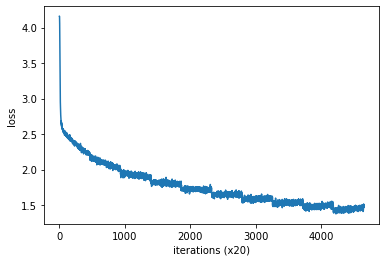

In [10]:
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs

In [11]:
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [12]:
print(word_vecs.shape)
pd.DataFrame(word_vecs).head()

(10000, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.236713,-0.117299,-0.006365,-0.114576,0.060531,0.001771,-0.158134,-0.069164,0.051583,-0.019689,...,0.102810,-0.056478,0.116110,0.067699,0.023076,0.254206,0.054230,-0.030597,-0.064052,-0.108704
1,-0.254277,-0.109647,-0.064672,-0.134657,0.139860,-0.037660,-0.278034,-0.052715,-0.017031,0.094290,...,0.154427,0.093717,0.038768,0.180491,-0.086085,0.362625,0.111742,0.031958,-0.135876,-0.118390
2,-0.241613,-0.118761,0.014658,-0.112703,0.105846,0.106285,-0.259071,-0.076968,-0.031567,0.126760,...,0.143406,0.162444,-0.105488,0.042027,-0.008726,0.417225,0.008128,0.187202,-0.169469,-0.052858
3,-0.254131,-0.340564,-0.078824,-0.299531,0.129427,0.177408,-0.175352,-0.144429,-0.065031,0.180208,...,0.211264,0.036855,-0.061734,0.056597,-0.063280,0.495307,0.089852,0.153215,-0.078645,0.029396
4,-0.330119,-0.360693,-0.137616,-0.397301,0.312317,0.265375,-0.205368,-0.137427,0.104744,0.085324,...,0.177185,0.107530,0.073628,-0.019810,-0.097058,0.448346,0.075293,0.253914,-0.171701,0.007611


### 4.3.3　CBOW モデルの評価

In [13]:
pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.708984375
 i: 0.69970703125
 your: 0.646484375
 they: 0.6064453125
 anybody: 0.59716796875

[query] year
 month: 0.84423828125
 summer: 0.77880859375
 week: 0.76953125
 spring: 0.755859375
 decade: 0.6884765625

[query] car
 window: 0.599609375
 truck: 0.58984375
 luxury: 0.57373046875
 auto: 0.5703125
 cars: 0.56005859375

[query] toyota
 seita: 0.65234375
 nissan: 0.65185546875
 honda: 0.638671875
 digital: 0.62890625
 nec: 0.62353515625


In [14]:
analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:king = woman:?
 artist: 4.1015625
 horse: 3.84375
 wife: 3.80859375
 hat: 3.728515625
 kid: 3.654296875


In [15]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top=5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 a.m: 5.88671875
 woman: 5.42578125
 mother: 4.671875
 lady: 4.51171875
 wife: 4.48828125

[analogy] take:took = go:?
 went: 4.8203125
 're: 4.71875
 came: 4.37109375
 eurodollars: 4.2734375
 were: 4.19140625

[analogy] car:cars = child:?
 a.m: 7.8359375
 daffynition: 5.671875
 bond-equivalent: 5.46484375
 children: 5.28125
 rape: 5.0546875

[analogy] good:better = bad:?
 rather: 5.64453125
 less: 5.328125
 more: 5.23046875
 greater: 4.48046875
 worse: 4.125
